In [ ]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using BenchmarkTools
using Random
using Plots

## State Estimation in a Linear Gaussian State-space Model

In this demo, the goal is to smooth noisy observations by performing full inference with a state-space model (SSM).

We wil use the following model:

\begin{equation} \label{eq:linear_gaussian_ssm}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}\mathbf{x}_{k - 1} + \mathcal{P} \\
    \mathbf{y}_k & = \, \mathbf{B}\mathbf{x}_{k} + \mathcal{Q} \\
  \end{aligned}
\end{equation}
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="pictures/ssm_model.eps" alt="Gaussian Linear State Space Model" style="width: 400px;"/>

For smoothing (forward-backward) estimation in ReactiveMP.jl, it is possible to build a full graph of the model.

In [ ]:
@model function linear_gaussian_ssm_full_graph(n, A, B, P, Q)
     
    x = randomvar(n) # Create a sequence of random variables
    y = datavar(Vector{Float64}, n) # Create a sequence of observed data points
    
    x[1] ~ MvGaussianMeanCovariance([ 0.0, 0.0 ], [ 100.0 0.0; 0.0 100.0 ]) # Set a prior distribution for x_1
    y[1] ~ MvGaussianMeanCovariance(B * x[1], Q)
    
    for t in 2:n
        x[t] ~ MvGaussianMeanCovariance(A * x[t - 1], P)
        y[t] ~ MvGaussianMeanCovariance(B * x[t], Q)    
    end
    
    return x, y
end

In [ ]:
function generate_data(n, A, B, P, Q; seed)
    Random.seed!(seed)

    x_prev = zeros(2)

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i] = rand(MvNormal(A * x_prev, P))
        y[i] = rand(MvNormal(B * x[i], Q))

        x_prev = x[i]
    end
   
    return x, y
end

In [10]:
seed = 1234
n = 100
θ = π / 15
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 1.0 0.0; 0.0 1.0 ]
Q = [ 1.0 0.0; 0.0 1.0 ]
θ = π / 15

real_x, real_y = generate_data(n, A, B, P, Q, seed = seed);

In [11]:
function inference_full_graph(observations, A, B, P, Q)
    n = length(observations) 
    
    model, (x, y) = linear_gaussian_ssm_full_graph(n, A, B, P, Q, options = (limit_stack_depth = 100, ))
    
    xbuffer = buffer(Marginal, n)
    fe      = nothing
    
    xsubscription = subscribe!(collectLatest(getmarginals(x)), xbuffer)
    fsubscription = subscribe!(score(BetheFreeEnergy(), model), (v) -> fe = v)
    
    update!(y, observations)
    
    unsubscribe!(xsubscription)
    unsubscribe!(fsubscription)
    
    return getvalues(xbuffer), fe
end

inference_full_graph (generic function with 1 method)

In [23]:
x_smoothing_inferred, fe_smoothing = inference_full_graph(real_y, A, B, P, Q);

In [13]:
reshape_data(data) = transpose(reduce(hcat, data))

reshape_data (generic function with 1 method)

In [14]:
using PGFPlotsX

PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

pgfplotsx();

In [16]:
full_graph_benchmark_results = map([ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 25_000, 50_000, 100_000 ]) do size
    states, observations = generate_data(size, A, B, P, Q, seed = seed);
    results, fe = inference_full_graph(observations, A, B, P, Q)
    benchmark   = @benchmark inference_full_graph($observations, $A, $B, $P, $Q)
    time        = mean(benchmark).time / 1000000
    gctime      = mean(benchmark.gctimes) / 1000000
    lower_bound = minimum(benchmark).time / 1000000
    upper_bound = maximum(benchmark).time / 1000000
    println("Completed $(size) with time $(time)ms")
    return (size, time, lower_bound, upper_bound, gctime, results, fe)
end

println("Completed")

Completed 50 with time 13.71191532513661ms
Completed 100 with time 28.527572301136363ms
Completed 250 with time 77.37165998461539ms
Completed 500 with time 167.47456543333334ms
Completed 1000 with time 369.6998255714286ms
Completed 2000 with time 900.132152ms
Completed 5000 with time 2289.3335296666664ms
Completed 10000 with time 4821.287684ms
Completed


In [18]:
@model function linear_gaussian_ssm_single_time_segment(A, B, P, Q)
    
    x_min_t_mean = datavar(Vector{Float64})
    x_min_t_cov  = datavar(Matrix{Float64})
    
    x_min_t ~ MvGaussianMeanCovariance(x_min_t_mean, x_min_t_cov)
    x_t     ~ MvGaussianMeanCovariance(A * x_min_t, P)
    
    y_t = datavar(Vector{Float64})
    y_t ~ MvGaussianMeanCovariance(B * x_t, Q)
    
    return x_min_t_mean, x_min_t_cov, x_t, y_t
end

linear_gaussian_ssm_single_time_segment (generic function with 1 method)

In [19]:
function inference_single_time_segment(observations, A, B, P, Q)
    n = length(observations) 
    
    model, (x_min_t_mean, x_min_t_cov, x_t, y_t) = linear_gaussian_ssm_single_time_segment(A, B, P, Q)
    
    xbuffer = keep(Marginal)
    fe      = keep(Real)
    
    redirect_to_prior_subscription = subscribe!(getmarginal(x_t), (x_t_posterior) -> begin
        update!(x_min_t_mean, mean(x_t_posterior))
        update!(x_min_t_cov, cov(x_t_posterior))    
    end)
    
    xsubscription = subscribe!(getmarginal(x_t), xbuffer)
    fsubscription = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    update!(x_min_t_mean, [ 0.0, 0.0 ])
    update!(x_min_t_cov, [ 100.0 0.0; 0.0 100.0 ])
    
    for observation in observations
        update!(y_t, observation)
    end
    
    unsubscribe!(xsubscription)
    unsubscribe!(fsubscription)
    unsubscribe!(redirect_to_prior_subscription)
    
    return getvalues(xbuffer), getvalues(fe)
end

inference_single_time_segment (generic function with 1 method)

In [20]:
x_filtering_inferred, fe_filtering = inference_single_time_segment(real_y, A, B, P, Q);

In [21]:
filtering_benchmark_results = map([ 50, 100, 250, 500, 1_000, 2_000, 5_000, 10_000, 25_000, 50_000, 100_000 ]) do size
    states, observations = generate_data(size, A, B, P, Q, seed = seed);
    results, fe = inference_single_time_segment(observations, A, B, P, Q)
    benchmark   = @benchmark inference_single_time_segment($observations, $A, $B, $P, $Q)
    time        = mean(benchmark).time / 1000000
    gctime      = mean(benchmark.gctimes) / 1000000
    lower_bound = minimum(benchmark).time / 1000000
    upper_bound = maximum(benchmark).time / 1000000
    println("Completed $(size) with time $(time)ms")
    return (size, time, lower_bound, upper_bound, gctime, results, fe)
end

println("Completed")

Completed 50 with time 3.853331161016949ms
Completed 100 with time 7.5575069969788515ms
Completed 250 with time 20.94413178661088ms
Completed 500 with time 46.08564ms
Completed 1000 with time 80.33302003174603ms
Completed 2000 with time 167.68918836666668ms
Completed 5000 with time 429.67847675ms
Completed 10000 with time 770.8905861428572ms
Completed 25000 with time 1971.1892993333333ms
Completed


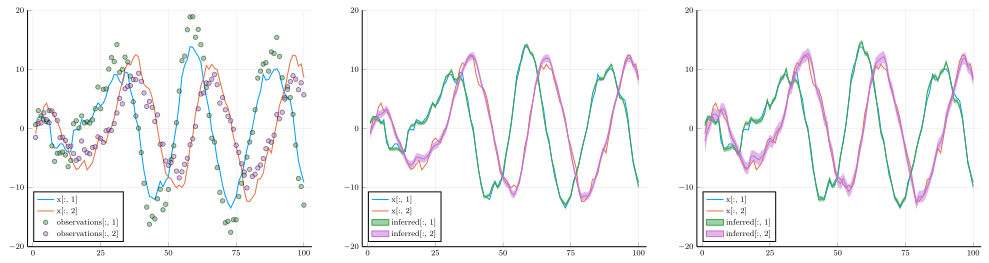

In [29]:
ylimit = (-20, 20)

generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 3, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft, ylimit = ylimit)

smoothing_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
smoothing_results_plot = plot!(smoothing_results_plot, 1:n, mean.(x_smoothing_inferred) |> reshape_data, ribbon = var.(x_smoothing_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
smoothing_results_plot = plot!(smoothing_results_plot, legend = :bottomleft, ylimit = ylimit)

filtering_results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
filtering_results_plot = plot!(filtering_results_plot, 1:n, mean.(x_filtering_inferred) |> reshape_data, ribbon = var.(x_filtering_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
filtering_results_plot = plot!(filtering_results_plot, legend = :bottomleft, ylimit = ylimit)

plot(generated_data, smoothing_results_plot, filtering_results_plot, layout = @layout([ a b c ]), size = (1400, 400))

In [31]:
savefig(generated_data, "./plots/linear_gaussian_ssm_data.tikz")
savefig(smoothing_results_plot, "./plots/linear_gaussian_ssm_smoothing_inference.tikz")
savefig(filtering_results_plot, "./plots/linear_gaussian_ssm_filtering_inference.tikz")

In [63]:
function plot_benchmark(benchmark_results; p = plot(), markershape = :diamond, label = "Mean execution time")
    p_sizes  = map(d -> d[1] , benchmark_results)
    p_mtime  = map(d -> d[2], benchmark_results)
    p_rtime  = map(d -> (d[3], d[4]), benchmark_results)
    p_gctime = map(d -> d[5], benchmark_results)

    p = plot!(p, p_sizes, p_mtime, xlabel = "Number of observation points", ylabel = "Time (in ms)", markershape = markershape, scale = :log10, label = label)
    # p = plot!(p, p_sizes, p_gctime, markershape = :utriangle, label = "Mean GC time")
    
    return p
end

plot_benchmark (generic function with 2 methods)

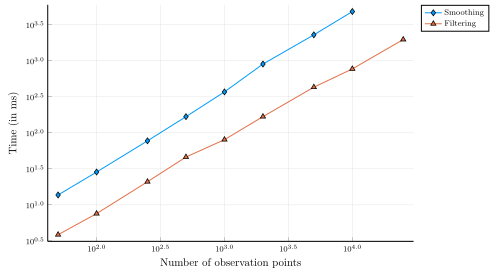

In [64]:
p1 = plot_benchmark(full_graph_benchmark_results, markershape = :diamond, label = "Smoothing")
p2 = plot_benchmark(filtering_benchmark_results, p = p1, markershape = :utriangle, label = "Filtering")

In [65]:
savefig(p2, "./plots/linear_gaussian_ssm_reactive_benchmarks.tikz")

In [39]:
import Pkg; Pkg.status(); versioninfo()

Status `~/Projects/Overleaf/RMP_Experiments/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [31c24e10] Distributions v0.24.14
  [b3f8163a] GraphPPL v0.1.0 `~/.julia/dev/GraphPPL.jl`
  [6218d12a] ImageMagick v1.1.6
  [91a5bcdd] Plots v1.10.5
  [a194aa59] ReactiveMP v0.5.0 `~/.julia/dev/ReactiveMP`
  [df971d30] Rocket v1.3.5 `~/.julia/dev/Rocket`
  [fce5fe82] Turing v0.15.10
Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
